<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Анализ восстановления золота из руды

Данный проект направлен на анализ данных по восстановлению различных минералов из исходной руды. 

Основная задача проекта подготовить данные и выводы, на основе которых возможно понять стоит ли проводить оптимизацию производства. 

## Подготовка данных

Подготавливаем необходимые библиотеки

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.metrics import mean_absolute_error
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyRegressor


RANDOM = 12345

Скачиваем исходные данные

In [3]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')


Анализируем исходные данные и чистим их

In [4]:
print(train.head())
print(train.shape)
train = train.drop_duplicates()
print(train.shape)
train.info()
print()
print(test.head())
print(test.shape)
test = test.drop_duplicates()
print(test.shape)
test.info()
print()
print(full.head())
print(full.shape)
full = full.drop_duplicates()
print(full.shape)
full.info()

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

Добавляем к тестовому датасету недостающие таргеты. Используем функцию merge, чтобы по индексу даты добавить значения. 

In [5]:
full_merge = full[['date', 'rougher.output.recovery', 'final.output.recovery']]

print(full_merge.info())

test = pd.merge(test,
 full_merge,
 on ='date',
 how ='left')

print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19439 entries, 0 to 19438
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     19439 non-null  object 
 1   rougher.output.recovery  19439 non-null  float64
 2   final.output.recovery    19439 non-null  float64
dtypes: float64(2), object(1)
memory usage: 607.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290 entries, 0 to 5289
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_clean

Проверяем эффективность обогащения

Эффективность обогащения рассчитывается по формуле
recovery = ((c*(f-t))/(f*(c-t)))*100%
где:
C — доля золота в концентрате после флотации/очистки;
F — доля золота в сырье/концентрате до флотации/очистки;
T — доля золота в отвальных хвостах после флотации/очистки.

Расчитаем эффективность обогощения - rougher.output.recovery

In [6]:

f_o_r = train["rougher.output.recovery"]
c = train["rougher.output.concentrate_au"]
f = train["rougher.input.feed_au"]
t = train["rougher.output.tail_au"]

recovery = ((c*(f-t))/(f*(c-t)))*100

In [7]:
print(f_o_r)
print(recovery)
print(mean_absolute_error(f_o_r, recovery))
print()

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64
0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64
9.73512347450521e-15



Довольно большое расхождение в размере


In [8]:
print(train.shape)
print(test.shape)
print()
print(train.columns)
print()
print(test.columns)


(14149, 87)
(5290, 55)

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level

В тестовой выборке нет финальных признаков. 
final.output.concentrate_ag'
final.output.concentrate_sol'
final.output.recovery'
final.output.tail_sol'
final.output.concentrate_pb'
final.output.concentrate_au'
final.output.tail_ag'
final.output.tail_au'

В первом этапе очистки нет параметров продуктов, а также параметра сырья сульфата
primary_cleaner.input.sulfate'
primary_cleaner.output.concentrate_ag'
primary_cleaner.output.concentrate_pb'
primary_cleaner.output.concentrate_sol'
primary_cleaner.output.concentrate_au'
primary_cleaner.output.tail_ag'
primary_cleaner.output.tail_sol'
primary_cleaner.output.tail_pb'
primary_cleaner.output.tail_au'

На втором этапе очистки нет параметров подукта - остатков хвостов
secondary_cleaner.output.tail_ag'
secondary_cleaner.output.tail_sol'
secondary_cleaner.output.tail_pb'
secondary_cleaner.output.tail_au'

Из этапа до обрабокти нет расчетных характеристик, а также некоторых параметров продуктов.
rougher.calculation.sulfate_to_au_concentrate'
rougher.calculation.floatbank10_sulfate_to_au_feed'
rougher.calculation.floatbank11_sulfate_to_au_feed'
rougher.calculation.au_pb_ratio'
rougher.output.concentrate_pb'
rougher.output.concentrate_au'
rougher.output.tail_ag'
rougher.output.tail_sol'
rougher.output.concentrate_ag'
rougher.output.concentrate_sol'
rougher.output.recovery'
rougher.output.tail_pb'
rougher.output.tail_au'







## Анализ данных

Проверяем как менялось  концентрация металлов (Au, Ag, Pb) на различных этапах очистки

   rougher.input.feed_au  rougher.output.concentrate_au  \
0               6.486150                      19.793808   
1               6.478583                      20.050975   
2               6.362222                      19.737170   
3               6.118189                      19.320810   
4               5.663707                      19.216101   

   primary_cleaner.output.concentrate_au  final.output.concentrate_au  
0                              34.174427                    42.192020  
1                              34.118526                    42.701629  
2                              33.969464                    42.657501  
3                              28.260743                    42.689819  
4                              33.044932                    42.774141  
rougher.input.feed_au                     7.866577
rougher.output.concentrate_au            19.439958
primary_cleaner.output.concentrate_au    32.386836
final.output.concentrate_au              44.003792
dtype: fl

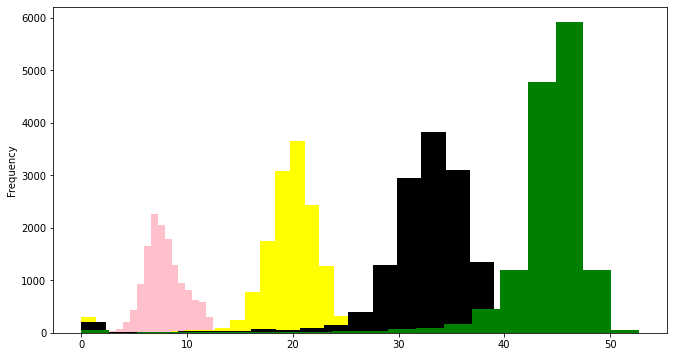

In [9]:
train_au = train[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
print(train_au.head())
print(train_au.mean())
print(train_au['final.output.concentrate_au'].mean() - train_au['rougher.input.feed_au'].mean())
train['rougher.input.feed_au'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'pink');
train['rougher.output.concentrate_au'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'yellow');
train['primary_cleaner.output.concentrate_au'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'black');
train['final.output.concentrate_au'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'green');




Как видно концентрация постоянно растет

   rougher.input.feed_ag  rougher.output.concentrate_ag  \
0               6.100378                      11.500771   
1               6.161113                      11.615865   
2               6.116455                      11.695753   
3               6.043309                      11.915047   
4               6.060915                      12.411054   

   primary_cleaner.output.concentrate_ag  final.output.concentrate_ag  
0                               8.547551                     6.055403  
1                               8.558743                     6.029369  
2                               8.603505                     6.055926  
3                               7.221879                     6.047977  
4                               9.089428                     6.148599  
rougher.input.feed_ag                     8.579195
rougher.output.concentrate_ag            11.775812
primary_cleaner.output.concentrate_ag     8.200916
final.output.concentrate_ag               5.142034
dtype: fl

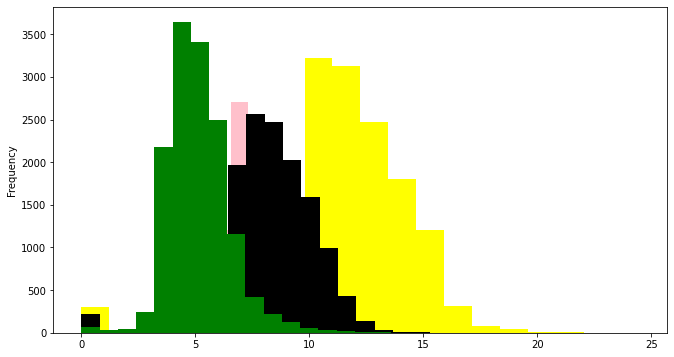

In [10]:
train_ag = train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
print(train_ag.head())
print(train_ag.mean())
print(train_ag['final.output.concentrate_ag'].mean() - train_ag['rougher.input.feed_ag'].mean())
train['rougher.input.feed_ag'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'pink');
train['rougher.output.concentrate_ag'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'yellow');
train['primary_cleaner.output.concentrate_ag'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'black');
train['final.output.concentrate_ag'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'green');



В данном материале концентрация растет на первичной обработке, но далее уменьшается

   rougher.input.feed_pb  rougher.output.concentrate_pb  \
0               2.284912                       7.101074   
1               2.266033                       7.278807   
2               2.159622                       7.216833   
3               2.037807                       7.175616   
4               1.786875                       7.240205   

   primary_cleaner.output.concentrate_pb  final.output.concentrate_pb  
0                              10.389648                     9.889648  
1                              10.497069                     9.968944  
2                              10.354494                    10.213995  
3                               8.496563                     9.977019  
4                               9.986786                    10.142511  
rougher.input.feed_pb                     3.522778
rougher.output.concentrate_pb             7.664555
primary_cleaner.output.concentrate_pb     9.588862
final.output.concentrate_pb              10.132960
dtype: fl

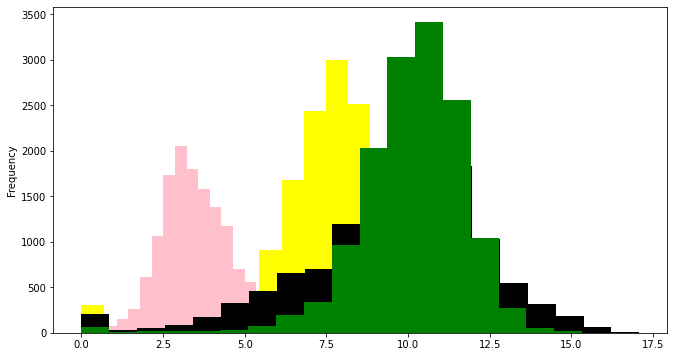

In [11]:
train_pb = train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
print(train_pb.head())
print(train_pb.mean())
print(train_pb['final.output.concentrate_pb'].mean() - train_pb['rougher.input.feed_pb'].mean())
train['rougher.input.feed_pb'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'pink');
train['rougher.output.concentrate_pb'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'yellow');
train['primary_cleaner.output.concentrate_pb'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'black');
train['final.output.concentrate_pb'].plot.hist(subplots=True, figsize=(11, 6), bins = 20, color = 'green');




Как видно концентрация постоянно растет

Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. 

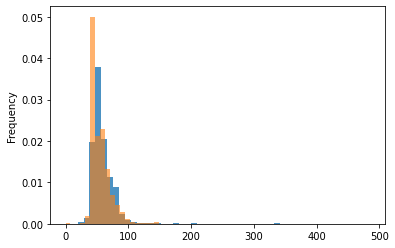

In [12]:
train_feed = train['rougher.input.feed_size']
test_feed = test['rougher.input.feed_size']

train_feed.plot.hist(alpha=0.8, density=True, bins = 50 );
test_feed.plot.hist(alpha=0.6, density=True, bins = 50);

print()



Тренировочная и тестовая выборки отличаются, но также имеют разный размер. Возьмем рандомно количетсво строчек из тренировочного датасета равное тестовому и посмотрим распределение.

(14149,)
(5290,)

0    77.216490
1    65.873226
2    52.874070
3    71.352716
4    62.119436
Name: rougher.input.feed_size, dtype: float64
(5290,)



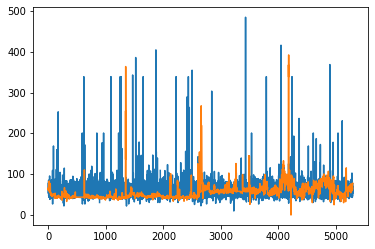

In [13]:
print(train_feed.shape)
print(test_feed.shape)
print()
train_feed = train_feed.sample(n=5290).reset_index(drop=True)
print(train_feed.head())
print(train_feed.shape)
print()
train_feed.plot();
test_feed.plot();




Как видно на данном графике размер сырья в целом идентичен.

Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

count    14149.000000
mean        19.943652
std          4.450475
min          0.030000
25%         16.850944
50%         19.179708
75%         22.571605
max         32.840164
dtype: float64

282182.73809811356


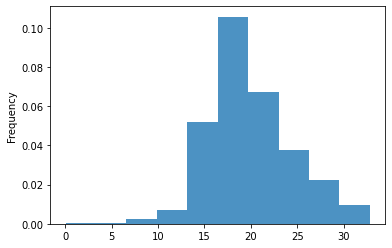

In [14]:
train_rougher_input_feed = train[['rougher.input.feed_pb', 'rougher.input.feed_au','rougher.input.feed_ag']].sum(axis=1)
print(train_rougher_input_feed.describe())
print()
print(train_rougher_input_feed.sum())
train_rougher_input_feed.plot.hist(alpha=0.8, density=True);


Видно, что в каждом кусочке есть один из отслеживаемых компонентов. Также медиана и среднее примерно совпадают, что значит в сырье нет сильных перекосов в зависимости от гранулы

count    14149.000000
mean        38.880325
std          6.927062
min          0.000000
25%         37.925621
50%         39.860389
75%         41.796805
max         55.568687
dtype: float64

550117.7172545104


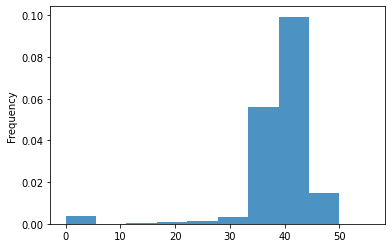

In [15]:
train_output_concentrate = train[['rougher.output.concentrate_pb', 'rougher.output.concentrate_au','rougher.output.concentrate_ag']].sum(axis=1)
print(train_output_concentrate.describe())
print()
print(train_output_concentrate.sum())
train_output_concentrate.plot.hist(alpha=0.8, density=True);



В этом и след шагах видно, что существуют кусочки, которые теряют необходимые компоненты при очистке, однако сумарная доля в целом растет.

count    14149.000000
mean        50.118331
std          7.995327
min          0.000000
25%         49.613974
50%         51.790269
75%         53.438138
max         60.269003
dtype: float64

709124.2659857341


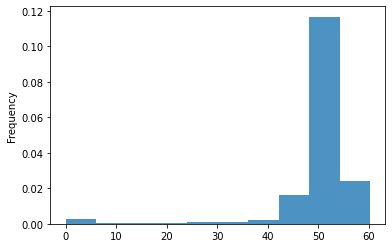

In [16]:
train_primary_cleaner_output_concentrate = train[['primary_cleaner.output.concentrate_pb', 'primary_cleaner.output.concentrate_au','primary_cleaner.output.concentrate_ag'  ]].sum(axis=1)
print(train_primary_cleaner_output_concentrate.describe())
print()
print(train_primary_cleaner_output_concentrate.sum())
train_primary_cleaner_output_concentrate.plot.hist(alpha=0.8, density=True);


count    14149.000000
mean        59.277705
std          5.711334
min          0.000000
25%         59.201505
50%         60.260341
75%         61.054829
max         64.968881
dtype: float64

838720.2530004559


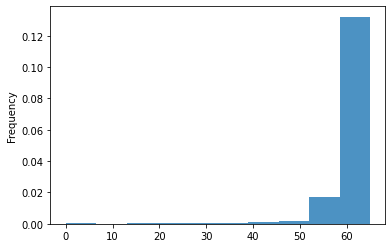

In [17]:
train_final_output_concentrate = train[['final.output.concentrate_pb', 'final.output.concentrate_au','final.output.concentrate_ag' ]].sum(axis=1)
print(train_final_output_concentrate.describe())
print()
print(train_final_output_concentrate.sum())
train_final_output_concentrate.plot.hist(alpha=0.8, density=True);





In [18]:
print(train_final_output_concentrate.mean() - train_rougher_input_feed.mean())

39.33405292970121


В среднем рост после очистки, в сравнении с исходым материалом значительно вырос.

Удалим из выборок значения с около 0й концентраицей.


count    13725.000000
mean        59.523187
std          4.158036
min          0.030000
25%         59.203123
50%         60.247172
75%         61.040789
max         64.968881
dtype: float64

816955.7391635408


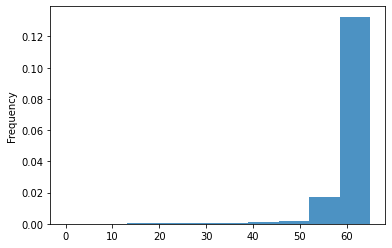

In [19]:
train = train.loc[train['rougher.input.feed_pb'] != 0]
train = train.loc[train['rougher.input.feed_au'] != 0]
train = train.loc[train['rougher.input.feed_ag'] != 0]
train = train.loc[train['rougher.input.feed_sol'] != 0]
train = train.loc[train['rougher.output.concentrate_pb'] != 0]
train = train.loc[train['rougher.output.concentrate_au'] != 0]
train = train.loc[train['rougher.output.concentrate_ag'] != 0]
train = train.loc[train['rougher.output.concentrate_sol'] != 0]
train = train.loc[train['primary_cleaner.output.concentrate_pb'] != 0]
train = train.loc[train['primary_cleaner.output.concentrate_au']  != 0]
train = train.loc[train['primary_cleaner.output.concentrate_ag'] != 0]
train = train.loc[train['primary_cleaner.output.concentrate_sol'] != 0]
train = train.loc[train['final.output.concentrate_pb'] != 0]
train = train.loc[train['final.output.concentrate_au']  != 0]
train = train.loc[train['final.output.concentrate_ag']  != 0]
train = train.loc[train['final.output.concentrate_sol'] != 0]
train_final_output_concentrate = train[['final.output.concentrate_pb', 'final.output.concentrate_au','final.output.concentrate_ag' ]].sum(axis=1)
print(train_final_output_concentrate.describe())
print()
print(train_final_output_concentrate.sum())
train_final_output_concentrate.plot.hist(alpha=0.8, density=True);

## Модель

Составим меры для нашей модели

In [20]:
print(train.isna().sum())


date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  207
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        1
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64


In [21]:
train = train.fillna(method='ffill')
print(train.isna().sum())

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64


Заполнил 0е значения

In [22]:
train_model = train.drop(['date'], axis=1)
train_model = train_model.dropna()
test_model = test.drop(['date'], axis=1)
test_model = test_model.dropna()

In [23]:
train_model = train_model.drop(['final.output.concentrate_ag',
'final.output.concentrate_sol',
'final.output.tail_sol',
'final.output.concentrate_pb',
'final.output.concentrate_au',
'final.output.tail_ag',
'final.output.tail_au',
'primary_cleaner.input.sulfate',
'primary_cleaner.output.concentrate_ag',
'primary_cleaner.output.concentrate_pb',
'primary_cleaner.output.concentrate_sol',
'primary_cleaner.output.concentrate_au',
'primary_cleaner.output.tail_ag',
'primary_cleaner.output.tail_sol',
'primary_cleaner.output.tail_pb',
'primary_cleaner.output.tail_au',
'secondary_cleaner.output.tail_ag',
'secondary_cleaner.output.tail_sol',
'secondary_cleaner.output.tail_pb',
'secondary_cleaner.output.tail_au',
'rougher.calculation.sulfate_to_au_concentrate',
'rougher.calculation.floatbank10_sulfate_to_au_feed',
'rougher.calculation.floatbank11_sulfate_to_au_feed',
'rougher.calculation.au_pb_ratio',
'rougher.output.concentrate_pb',
'rougher.output.concentrate_au',
'rougher.output.tail_ag',
'rougher.output.tail_sol',
'rougher.output.concentrate_ag',
'rougher.output.concentrate_sol',
'rougher.output.tail_pb',
'rougher.output.tail_au',
], axis=1)

Создадим функцию

In [24]:
def smape(x, y):
    x = np.array(x)
    y = np.array(y)

    smape = (1/len(x))*sum((abs(x-y)/((abs(x)+abs(y))/2)))*100
    return smape

In [25]:
features = train_model.drop(['final.output.recovery','rougher.output.recovery'], axis = 1)
target_final = train_model['final.output.recovery']
target_rougher = train_model['rougher.output.recovery']

Проверим модели

In [26]:
linearregression = LinearRegression()

In [27]:
linearregression_fin = cross_val_score(linearregression, features, target_final,
                                  scoring=make_scorer(smape, greater_is_better = False), cv=5) 
print(linearregression_fin.mean())

linearregression_rou = cross_val_score(linearregression, features, target_rougher,
                                  scoring=make_scorer(smape, greater_is_better = False), cv=5) 
print(linearregression_rou.mean())

-11.377251205036368
-7.3075014086330725


In [28]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 30, 40],
    'max_features': [2,3],
    'min_samples_leaf': [3],
    'min_samples_split': [2,3],
    'n_estimators': [20,40,60,80,100,120]
}

rf = RandomForestRegressor()

grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2).fit(features, target_final)
best_parameters_final = grid_search_final.best_params_
best_estimator_final = grid_search_final.best_estimator_
cv_rfc_final = cross_val_score(best_estimator_final,features, target_final, scoring=make_scorer(smape, greater_is_better = False), cv=4)
print(best_parameters_final)
print(cv_rfc_final.mean())

grid_search_rougher = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2).fit(features, target_rougher)
best_parameters_rougher = grid_search_rougher.best_params_
best_estimator_rougher = grid_search_rougher.best_estimator_
cv_rfc_rougher = cross_val_score(best_estimator_rougher,features, target_final, scoring=make_scorer(smape, greater_is_better = False), cv=4)
print(best_parameters_rougher)
print(cv_rfc_rougher.mean())


Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=20; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=40; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=40; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=60; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=60; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=80; total time=   1.0s
[CV] END boots

In [29]:
clf = linear_model.ARDRegression()

clf_fin = cross_val_score(clf, features, target_final, scoring=make_scorer(smape, greater_is_better = False), cv=5) 
print(clf_fin.mean())

clf_rou = cross_val_score(clf, features, target_rougher, scoring=make_scorer(smape, greater_is_better = False), cv=5) 
print(clf_rou.mean())

-11.788432036371859
-7.285309211956729


In [30]:
test_features = test_model.drop(['final.output.recovery','rougher.output.recovery'], axis = 1)
test_target_final = test_model['final.output.recovery']
test_target_rougher = test_model['rougher.output.recovery']

In [31]:
cv_rfc_fin = best_estimator_final.predict(test_features)
cv_rfc_rou = best_estimator_rougher.predict(test_features)

dummy_regr = DummyRegressor(strategy="mean")
cv_dum_fin = dummy_regr.fit(features, target_final)
cv_dum_fin = cv_dum_fin.predict(test_features)
cv_dum_rou = dummy_regr.fit(features, target_rougher)
cv_dum_rou = cv_dum_rou.predict(test_features)



print(0.25*cv_rfc_rou.mean() +0.75*cv_rfc_fin.mean())
print(0.25*cv_dum_rou.mean() +0.75*cv_dum_fin.mean())


69.10248978745568
71.23387029926104


In [39]:
print(smape(test_target_final, cv_rfc_fin))
print(smape(test_target_rougher, cv_rfc_rou))



print(0.25*smape(test_target_rougher, cv_rfc_rou)+0.75*smape(test_target_final, cv_rfc_fin))
print(0.25*smape(test_target_rougher, cv_dum_rou)+0.75*smape(test_target_final, cv_dum_fin))



11.233281428602359
8.840992712637718
10.635209249611197
9.408622604727634


Вывод

Данный проект был направлен на анализ данных по восстановлению различных минералов из исходной руды. 

На 1м этапе была проверенна эффективность обогащения рассчитана. Метрика считается корректно.
Далее были проверены отсутвующие данные в тестовой выборке, посел проверки были добавлены недостоющие таргеты и удалены лишное столбцы.

При проверке эффективности очистки было выявлено, что практически все этапы очистки увеличивают долю необходимого сырья. 
Также было выявлено, что сырье иммеет примерно схожий размер во всех выборках, что позволяет корректно расчитывать данные в моделях.

При проверке моделей наиболее эффективной показала себя модель - RandomForestRegressor. Однако даже данная модель имеет выше вероятноть ошибки чем DummyRegressor, которая просто усредняет данные.  